# Population Segmentation

Welcome in this notebook. In this notebook I will investigate the similarities of different counties in the US based on different features. Grouping different counties together is used for market research, pattern recognition, image processing and targeted campaigns by political parties. 

First I will start by importing and analyzing the data. Second, I will perform PCA analysis to reduce the dimensionality of the data. At last, I will apply the K-means algorithm to group similar datapoints together. I will also try to find the best value for the hyperparameter K (number of clusters) using the elbow and silhouette scores. 

## 1. Import the data
First, import libraries to this SageMaker notebook.

In [2]:
#Data processing libraries
import pandas as pd
import numpy as np
import os
import io

#Display libraries
import matplotlib.pyplot as plt
import matplotlib

#To plot in this notebook
%matplotlib inline 

#Sagemaker libraries
import sagemaker
import boto3 #Allows us to create, update and delete other AWS resources from within this notebook

The data we need is stored in an Amazon S3 Bucket. We can load it by pointing to the specific bucket. We will interact with S3 using a boto3 client. 

In [3]:
s3_client = boto3.client("s3")
bucket_name = 'aws-ml-blog-sagemaker-census-segmentation'

Take a look at the contents of the bucket.

In [4]:
objects_list = s3_client.list_objects(Bucket=bucket_name)
print(objects_list)

{'ResponseMetadata': {'RequestId': '7W8Q2RFSCQ6S2YCT', 'HostId': 'tTLPF/EYbgxRTT0V3Nv+RVubgbdzNqfw8Y876Ic1XfwQkkiYOxgKUpxpNf3Iu643h2R04Mt4UIo=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'tTLPF/EYbgxRTT0V3Nv+RVubgbdzNqfw8Y876Ic1XfwQkkiYOxgKUpxpNf3Iu643h2R04Mt4UIo=', 'x-amz-request-id': '7W8Q2RFSCQ6S2YCT', 'date': 'Fri, 21 Aug 2020 13:47:22 GMT', 'x-amz-bucket-region': 'us-east-1', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 1}, 'IsTruncated': False, 'Marker': '', 'Contents': [{'Key': 'Census_Data_for_SageMaker.csv', 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzlocal()), 'ETag': '"066d37f43f7762f1eb409b1660fe9763"', 'Size': 613237, 'StorageClass': 'STANDARD'}], 'Name': 'aws-ml-blog-sagemaker-census-segmentation', 'Prefix': '', 'MaxKeys': 1000, 'EncodingType': 'url'}


From the above response, we need the Census_Data_for_SageMaker.csv, which is the Key in Contents. Content contains all the objects that are returned with additional metadata. 

In [5]:
file_name = objects_list["Contents"][0]["Key"]
print(file_name)

Census_Data_for_SageMaker.csv


We want to retrieve the data in this object, we do that using the get_object() function.

In [6]:
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

What information does the object contain?

In [7]:
display(data_object)

{'ResponseMetadata': {'RequestId': 'A5AD5D87B6F4252C',
  'HostId': 'cpNQanFxH1IXnfg6G6YZ0u7hhhWu7IrtwlOsEmam9Hi3pUrl9ZtvePeJR4eHo/ywKVEXOOHp/s4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'cpNQanFxH1IXnfg6G6YZ0u7hhhWu7IrtwlOsEmam9Hi3pUrl9ZtvePeJR4eHo/ywKVEXOOHp/s4=',
   'x-amz-request-id': 'A5AD5D87B6F4252C',
   'date': 'Fri, 21 Aug 2020 13:47:23 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f78f19c4198>}

The information is contained in the body. Lets read it in. 

In [8]:
data_body = data_object["Body"].read()
print("type(data_body) = {}".format(type(data_body)))

type(data_body) = <class 'bytes'>


Read in the bytes data using io.BytesIO(fille). 

In [9]:
data_stream = io.BytesIO(data_body)
print(data_stream)

Create a dataframe with the data_stream variable.

In [10]:
counties_df = pd.read_csv(data_stream, header=0, delimiter=",") 
counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## 2. Preprocess Data
Now it is time to explore, clean and preprocess the data. 

In [11]:
counties_df.shape

(3220, 37)

In [12]:
counties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusId         3220 non-null   int64  
 1   State            3220 non-null   object 
 2   County           3220 non-null   object 
 3   TotalPop         3220 non-null   int64  
 4   Men              3220 non-null   int64  
 5   Women            3220 non-null   int64  
 6   Hispanic         3220 non-null   float64
 7   White            3220 non-null   float64
 8   Black            3220 non-null   float64
 9   Native           3220 non-null   float64
 10  Asian            3220 non-null   float64
 11  Pacific          3220 non-null   float64
 12  Citizen          3220 non-null   int64  
 13  Income           3219 non-null   float64
 14  IncomeErr        3219 non-null   float64
 15  IncomePerCap     3220 non-null   int64  
 16  IncomePerCapErr  3220 non-null   int64  
 17  Poverty       

In [13]:
counties_df.describe()

,CensusId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3220.000000,3.220000e+03,3.220000e+03,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,...,3220.000000,3220.000000,3220.000000,3220.000000,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000
mean,31393.605280,9.940935e+04,4.889694e+04,5.051241e+04,11.011522,75.428789,8.665497,1.723509,1.229068,0.082733,...,3.323509,1.612733,4.631770,23.278758,4.559352e+04,74.219348,17.560870,7.931801,0.288106,8.094441
std,16292.078954,3.193055e+05,1.566813e+05,1.626620e+05,19.241380,22.932890,14.279122,7.253115,2.633079,0.734931,...,3.756096,1.670988,3.178772,5.600466,1.496995e+05,7.863188,6.510354,3.914974,0.455137,4.096114
min,1001.000000,8.500000e+01,4.200000e+01,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.900000,6.200000e+01,25.000000,5.800000,0.000000,0.000000,0.000000
25%,19032.500000,1.121800e+04,5.637250e+03,5.572000e+03,1.900000,64.100000,0.500000,0.100000,0.200000,0.000000,...,1.400000,0.900000,2.700000,19.500000,4.550750e+03,70.500000,13.100000,5.400000,0.100000,5.500000
50%,30024.000000,2.603500e+04,1.293200e+04,1.305700e+04,3.900000,84.100000,1.900000,0.300000,0.500000,0.000000,...,2.400000,1.300000,3.900000,23.000000,1.050800e+04,75.700000,16.200000,6.900000,0.200000,7.600000
75%,46105.500000,6.643050e+04,3.299275e+04,3.348750e+04,9.825000,93.200000,9.600000,0.600000,1.200000,0.000000,...,4.000000,1.900000,5.600000,26.800000,2.863275e+04,79.700000,20.500000,9.400000,0.300000,9.900000
max,72153.000000,1.003839e+07,4.945351e+06,5.093037e+06,99.900000,99.800000,85.900000,92.100000,41.600000,35.300000,...,71.200000,39.100000,37.200000,44.000000,4.635465e+06,88.300000,66.200000,36.600000,9.800000,36.500000


In [14]:
#Check for missing values
counties_df.isna().sum()

CensusId           0
State              0
County             0
TotalPop           0
Men                0
Women              0
Hispanic           0
White              0
Black              0
Native             0
Asian              0
Pacific            0
Citizen            0
Income             1
IncomeErr          1
IncomePerCap       0
IncomePerCapErr    0
Poverty            0
ChildPoverty       1
Professional       0
Service            0
Office             0
Construction       0
Production         0
Drive              0
Carpool            0
Transit            0
Walk               0
OtherTransp        0
WorkAtHome         0
MeanCommute        0
Employed           0
PrivateWork        0
PublicWork         0
SelfEmployed       0
FamilyWork         0
Unemployment       0
dtype: int64

In [15]:
#Drop the rows with missing values
counties_df.dropna(axis=0, inplace=True)

In [16]:
#Check again for missing values
counties_df.isna().sum()

CensusId           0
State              0
County             0
TotalPop           0
Men                0
Women              0
Hispanic           0
White              0
Black              0
Native             0
Asian              0
Pacific            0
Citizen            0
Income             0
IncomeErr          0
IncomePerCap       0
IncomePerCapErr    0
Poverty            0
ChildPoverty       0
Professional       0
Service            0
Office             0
Construction       0
Production         0
Drive              0
Carpool            0
Transit            0
Walk               0
OtherTransp        0
WorkAtHome         0
MeanCommute        0
Employed           0
PrivateWork        0
PublicWork         0
SelfEmployed       0
FamilyWork         0
Unemployment       0
dtype: int64

We are going to concatenate the "State" and "County" feature to a new features called "state-county" and make this column the index. This way we are left with only numerical data that we can feed to a Machine Learning model. 

In [17]:
#Concatenate the state and county columns
counties_df.index = counties_df["State"] + "-" + counties_df["County"]

counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


Lastly, we drop the old "State" and "County" columns. Also we drop the "CensusId" columns as this is unique for each row in our dataset

In [18]:
counties_df.drop(["State", "County", "CensusId"], axis=1, inplace=True)

What features do we have to work with?

In [19]:
features_list = counties_df.columns.values
print(features_list)

['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## 3. Visualizing the Data

Lets visualize how people transport to work. We look at the following features: Drive, Carpool, Transit, Walk, OtherTranp

In [20]:
#The values are percentages of the people that go to work with a specific transportation medium. 
counties_df[["Drive", "Carpool", "Transit", "Walk", "OtherTransp"]]

,Drive,Carpool,Transit,Walk,OtherTransp
Alabama-Autauga,87.5,8.8,0.1,0.5,1.3
Alabama-Baldwin,84.7,8.8,0.1,1.0,1.4
Alabama-Barbour,83.8,10.9,0.4,1.8,1.5
Alabama-Bibb,83.2,13.5,0.5,0.6,1.5
Alabama-Blount,84.9,11.2,0.4,0.9,0.4
...,...,...,...,...,...
Puerto Rico-Vega Baja,89.1,7.1,0.9,1.2,1.3
Puerto Rico-Vieques,69.1,17.8,1.0,10.8,0.0
Puerto Rico-Villalba,82.0,11.4,0.1,3.2,0.0
Puerto Rico-Yabucoa,86.0,7.9,0.0,2.3,2.3


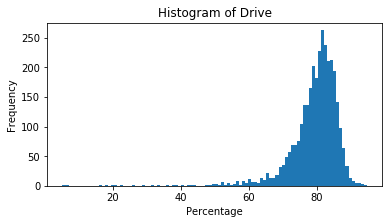

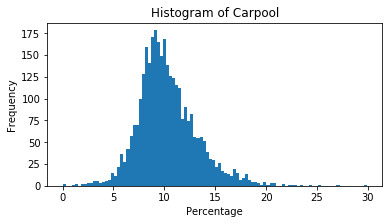

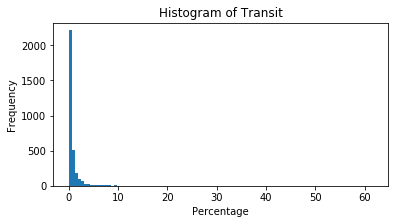

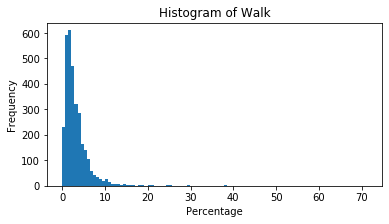

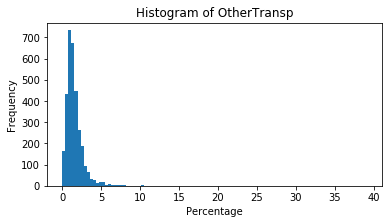

In [22]:
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']

for column_name in transport_list:
    
    ax = plt.subplots(figsize=(6,3))
    ax = plt.hist(counties_df[column_name], bins=100)
    plt.xlabel("Percentage")
    plt.ylabel("Frequency") #How many data point fall in a specific range?
    plt.title("Histogram of " + column_name, fontsize=12)
    plt.show()

Normalize the data in order to consistantly compare the values of different features. 

In [23]:
from sklearn.preprocessing import MinMaxScaler

#Make the scaler object
scaler = MinMaxScaler()

#Fit the scaler to the data
counties_scaled = scaler.fit_transform(counties_df)

#Add the column-names to the normalized data
counties_scaled = pd.DataFrame(counties_scaled, columns=features_list)

#Add the index to the normalized data
counties_scaled.index = counties_df.index

#Look at the head of the data
counties_scaled.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


## 4. Data Modeling
In this section we are going to model the data. We will be using the K-means algorithm to cluster the data. Because our data has high dimensionality (34 features vs 3000+ samples), it is difficult for the K-means algorithm to figure out which features are most important and the clusters will become much noiser. That is why we will use PCA, a dimensionality reduction technique. 

### 4.1 Dimensionality Reduction
First, lets get our IAM Role we created at the time we created this notebook instance (FullAccess). Also, we need an S3 bucket to store the model artifacts. 

In [24]:
import sagemaker
from sagemaker import get_execution_role

#Create a SageMaker Session to manage interactions with the Amazon Sagemaker APIs and any other AWS services needed. 
session = sagemaker.Session()

#Get the IAM Role
role = get_execution_role()
print(role)

arn:aws:iam::513808683464:role/service-role/AmazonSageMaker-ExecutionRole-20200727T124755


In [25]:
#Get the default bucket
bucket_name = session.default_bucket() #Create the bucket
print(bucket_name)

sagemaker-eu-central-1-513808683464


Before we built the PCA Model, we will define the location on S3 where we want to store the model artifacts. Thereafter, we will define the PCA model using SageMakers built-in PCA Model. 

In [26]:
#Define location to store model artifacts
prefix_pca = "PCA"
output_path = "s3://{}/{}/".format(bucket_name, prefix_pca)
print("Training artifacts will be stored in: {}".format(output_path))

Training artifacts will be stored in: s3://sagemaker-eu-central-1-513808683464/PCA/


In [27]:
#Define the PCA Model
from sagemaker import PCA

#Choose amount of principal components
N_COMPONENTS = 33

#Define the model
pca_SM = PCA(role=role,
            train_instance_count=1,
            train_instance_type="ml.c4.xlarge",
            num_components=N_COMPONENTS,
            output_path=output_path,
            sagemaker_session=session)

Convert the data to a RecordSet object. This is what the fit method expects. To make a RecordSet object, we need to have a numpy array first.

##### Note on RecordSet: 

The record_set function in the Amazon SageMaker PCA model converts a numpy array into a record set format that is the required format for the input data to be trained. This is a requirement for all Amazon SageMaker built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, for larger data sets compared with other implementations of the same models, such as the sklearn implementation.

In Python terms, a record is an instance of any class for which you define some attributes but no methods. Such classes, which are known as record types, can be easily written but require a lot of noisy boilerplate. (https://pythonhosted.org/pyrecord/#:~:text=In%20Python%20terms%2C%20a%20record,a%20lot%20of%20noisy%20boilerplate.)

In [28]:
#convert DataFrame to numpy array
train_data_np = counties_scaled.values.astype("float32")
print(train_data_np.shape)

#Convert numpy array to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np) #a folder "sagemaker-record-sets" is created to S3. 
#The collection of Record objects are protobuf serialized and uploaded to new S3 locations. 
#A manifest file is generated containing the list of objects created and is also stored in S3.

print(type(formatted_train_data))
print(formatted_train_data)

(3218, 34)
<class 'sagemaker.amazon.amazon_estimator.RecordSet'>
(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-eu-central-1-513808683464/sagemaker-record-sets/PCA-2020-08-21-13-48-28-904/.amazon.manifest', 'feature_dim': 34, 'num_records': 3218, 's3_data_type': 'ManifestFile', 'channel': 'train'})


#### Train the model
Now it is time to train the PCA model.

In [29]:
%%time

#train the PCA model on the formatted data
pca_SM.fit(formatted_train_data)

#After training, a new folder is created in the S3 bucket called "PCA", 
#which contains: <trainingjobname>/output/model.tar.gz. In the model.tar.gz file the model artifacts are stored. 
#The stored artifacts can be used to deploy a trained model. 

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-21 13:48:33 Starting - Starting the training job...
2020-08-21 13:48:35 Starting - Launching requested ML instances......
2020-08-21 13:49:41 Starting - Preparing the instances for training......
2020-08-21 13:50:59 Downloading - Downloading input data
2020-08-21 13:50:59 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/21/2020 13:51:15 INFO 139983836251968] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[08/21/2020 13:51:15 INFO 139983836251968] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_components':

#### Accessing the PCA Attributes


In [30]:
#Copy the job name from the SageMaker console. 
training_job_name = "pca-2020-08-21-13-48-33-537"

#Location of the saved model in S3
model_key = os.path.join(prefix_pca, training_job_name, "output/model.tar.gz") #prefix_pca="PCA"
print(model_key)

#Make an S3 resource. This gives us higher level service access to S3, in contrast to a client, which gives low level access to S3
s3 = boto3.resource("s3") 
print(s3)

s3_bucket = s3.Bucket(bucket_name) #A resource representing an Amazon Simple Storage Service (S3) Bucket
print(s3_bucket)

#Download the S3 object to a file
s3_bucket.download_file(model_key, "model.tar.gz") #The model is saved in the working directory as "model.tar.gz"

#Unzip the model files
os.system("tar -zxvf model.tar.gz") #Return a file called model_algo-1 in the working directory
os.system("unzip model_algo-1") #Unzip the model_algo-1 file


PCA/pca-2020-08-21-13-48-33-537/output/model.tar.gz
s3.ServiceResource()
s3.Bucket(name='sagemaker-eu-central-1-513808683464')


2304

##### Note on model_algo-1

Trained Model Deserialization

Amazon SageMaker models are stored as model.tar.gz in the S3 bucket specified in OutputDataConfig S3OutputPath parameter of the create_training_job call. You can specify most of these model artifacts when creating a hosting model. You can also open and review them in your notebook instance. When model.tar.gz is untarred, it contains model_algo-1, which is a serialized Apache MXNet object. (https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html)

In [31]:
import mxnet as mx

#Deserialize the MXNet object
pca_model_params = mx.ndarray.load("model_algo-1")

print(pca_model_params)

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


The PCA model attributes consists of 3 parts: 

- Mean: The mean that was substracted from a component in order to center it
- v: The Makeup of the principal components (the eigenvectors of the covariance matrix)
- s: The singular values of the components for the PCA transformation (eigenvalues). Gives the percentage of variance captured by the principal components. 

In [32]:
#Get the parameters

s = pd.DataFrame(pca_model_params["s"].asnumpy())
v = pd.DataFrame(pca_model_params["v"].asnumpy())
s

,0
0,0.017896
1,0.030864
2,0.032131
3,0.035486
4,0.094832
5,0.126994
6,0.402887
7,1.408476
8,1.510049
9,1.595794


The s values give the variance contributed by the different principal components. The higher the value, the more the contribution of that specific principal component on the data. In other words, it contributes more to the variance of the data. Lets check the top 5 principal components. 

In [33]:
n_principal_components = 5

#Make an index variable to capture the n_principal_components
start_idx = N_COMPONENTS - n_principal_components

#print a selection of s
print(s.iloc[start_idx:, :])

            0
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180


We want to create new training data. For this reason, we need to make sure we don't lose to much of the variance of the original data, which is 100%. We want to capture at least 80% of the total variance in the dataset. To do this, we first write a function which calculates the percentage of captured variance given the n_top_components we wish to use. 

In [34]:
def explained_variance(s, n_top_components):
    
    """
    Calculates the explained variance given the singular values of the principal components s and the n_top_components to use
    
    Args
    -------
    s: singular values of the principal components
    n_top_components: (int) representing the n top components for which we want to calculate the explained variance. 
    
    Returns
    -------
    var[0]: the explained variance which is a percentage
    """
    
    #Change the column name to reference to it later
    s.columns = ["s"] 
    
    #Sort the rows of s to descending form
    s = s.sort_values("s", ascending=False)
        
    #Calculate the expected data variance covered by top n principal components      
    var = np.square(s.iloc[:n_top_components]).sum() / np.square(s).sum()

    return var[0]

#For example, the top 7 principal component accounts for 80% of our data variance. 
explained_variance(s, 7)

0.80167246

Each Principal Components is made up of a weighted linear combination of the original features of the dataset. We can look for ourselves how each principal component is made up. For this, we create a function called display_component which will display for a given principal component which combinations it is made up of. Lets first print out s and v. 

In [35]:
print(s)
print(v) 
#v has a shape of (34,33). We have 33 principal components and each principal component is made up of 
#a weighted linear combination of the original 34 features. 

            s
0    0.017896
1    0.030864
2    0.032131
3    0.035486
4    0.094832
5    0.126994
6    0.402887
7    1.408476
8    1.510049
9    1.595794
10   1.778376
11   2.166252
12   2.296636
13   2.385605
14   2.695488
15   2.806798
16   3.017596
17   3.395267
18   3.573130
19   3.696696
20   4.189021
21   4.345750
22   4.541038
23   5.018966
24   5.578647
25   5.980970
26   6.392514
27   7.695221
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180
          0         1         2         3         4         5         6   \
0   0.002469  0.025647  0.002508  0.001504 -0.323074 -0.178807 -0.001509   
1  -0.028060 -0.686634 -0.019628 -0.041537 -0.331368 -0.241622 -0.001658   
2   0.032577  0.717301  0.024073  0.045103 -0.315083 -0.117787 -0.001385   
3   0.000218 -0.000916 -0.000623 -0.000381 -0.001569  0.010348 -0.495563   
4   0.000242 -0.000709 -0.000601 -0.000256 -0.002276  0.010803 -0.501500   
5   0.000239 -0.001190 -0.000525 -0.000278 -0.001989  0.008303 -0.42

In [36]:
import seaborn as sns

def component_makeup(v, features_list, component_num, n_weights):
    
    """
    Calculates the makeup of each principal component. Each principal component is a weighted linear combination
    of the features of the dataset. 
    
    Args
    -------
    v            : (dataframe) containing the PCA model v parameter.
    features_list: (array/list) containing the features of the dataset on which PCA is performend.
    component_num: (int) which principal component to make the makeup of.
    n_weights    : (int) top n_weights will be plotted.
    
    Returns
    -------
    Barplot with makeup of the selected principal component
    """
    
    #Get the index of the principal componennt we want to examine. 
    row_idx = N_COMPONENTS - component_num

    #Get the makeup of the principal component (eigenvector)
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values) #v_1 is an array with shape (34,) and contains the makeup of the principal component

    #Match the weights to features in the counties_scaled dataframe
    comp_makeup = pd.DataFrame(list(zip(v_1, features_list)), columns = ["weights", "features"])

    #Sort by the largest absolute weights. For this, we add a extra columns with the absolute weights
    comp_makeup["abs_weights"] = comp_makeup["weights"].apply(lambda x: np.abs(x))
    sorted_comp_makeup = comp_makeup.sort_values(["abs_weights"], ascending=False, ignore_index=True)

    #Show only the top n_weights
    sorted_comp_makeup = sorted_comp_makeup.head(n_weights)

    #Plot the component makeup with seaborn
    ax = plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_comp_makeup,
                   x="weights",
                   y="features")
    ax.set_title("PCA Component makeup, Component #{}".format(str(component_num)))
    plt.show()

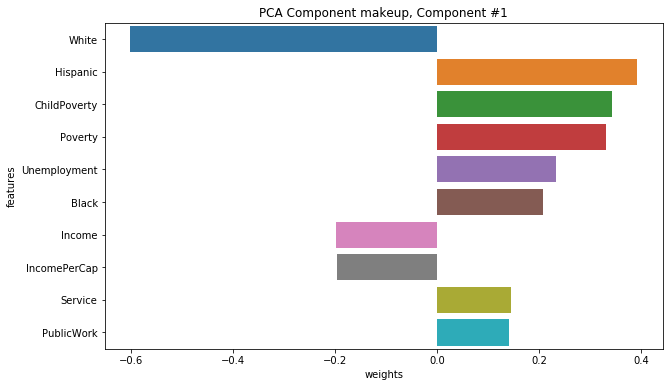

In [37]:
component_makeup(v, features_list, 1, 10)

From the above plot, we can see that the first principal component is a weighted linear combination of the different features. 

#### Deploy the PCA Model
We will deploy the PCA Model. If a model has been deployed it means that SageMaker has created a virtual machine that contains our trained model that can be accessed at an endpoint (endpoint=url). 

In [44]:
%%time

#Deplot the model
pca_predictor = pca_SM.deploy(initial_instance_count=1,
                             instance_type="ml.t2.medium")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: pca-2020-08-21-13-48-33-537


-----------------!CPU times: user 325 ms, sys: 13 ms, total: 338 ms
Wall time: 8min 33s


Up untill here, we found 33 principal components. Each component carries with it some of the variance of the data. What we want to do now, is transform our data using this PCA model. What happens here is that each datapoint is mapped to the principal components space. We can use our model to transform the training data. 

In [45]:
train_pca = pca_predictor.predict(train_data_np)

In [46]:
#Check train_pca
print("Length of train_pca = {}".format(len(train_pca)))
print("type of elements in train_pca: {}".format(type(train_pca[0])))

#Look at one element of the list
print(train_pca[0])

#Each datapoint has its representation in the Principal Component space. E.g. the output below shows the representation of
#the first datapoint in the PC space. 

Length of train_pca = 3218
type of elements in train_pca: <class 'record_pb2.Record'>
label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.0024792551994323

Now, lets create a function create_transformed_df to create dimensionality-reduced data

In [47]:
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    
    """ 
    Creates a dataframe of datapoints with the principal components as features.
    
    Args
    -------
    train_pca       : (list) contains pca training data returned by a pca model.
    counties_scaled : (dataframe) dataframe of normalized, original features.
    n_top_components: (int) the number of top principal components to use.
    
    Returns
    -------
    A dataframe, indexed by State-County, with n_top_component columns. This dataframe is in the principal component space. 
    """
    
    #Create an empty dataframe
    df = pd.DataFrame()
    
    #Create an idx variable to get only the n_top_components
    idx = counties_scaled.shape[1] - n_top_components - 1
    
    #Add to the dataframe
    for i in train_pca:
        data_list = list(i.label["projection"].float32_tensor.values)[idx:]
        data = pd.DataFrame([data_list]) #the brackets around list ensures we add rows to dataframe
        df = df.append(data)
    
    #Set the index of the dataframe
    df.index = counties_scaled.index
    
    return df.iloc[:, ::-1] #Columns in reversed order, so top component will be first column

In [48]:
#Create the transformed dataframe with top 7 components (this captured around 80% of the variance as we saw earlier)
counties_transformed = create_transformed_df(train_pca, counties_scaled, 7)

#Change the column names
counties_transformed.columns = ["c_1", "c_2","c_3","c_4","c_5","c_6","c_7"] #principal components 1,2,3,4,5,6,7

#Look at the transformed dataset
counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


At this point, we have transformed our data. We went from data with 34 features to more compact data with 7 features using Principal Component Analysis. The lower dimensional data is still able to capture about 80% of the variance of the original data. Now, we can delete our PCA endpoint. 

In [49]:
#Delete the endpoint
pca_predictor.delete_endpoint()
print("Endpoint with name {} is deleted".format(pca_predictor.endpoint))

Endpoint with name pca-2020-08-21-13-48-33-537 is deleted


Now that we have our training code ready, we can save it locally. If it already exists, import it to the notebook. This point of the notebook works like a checkpoint, if all the PCA analysis is done, we can continue from here to cluster the data with K-means. 

In [50]:
import os
import pandas as pd

kmeans_file = "train_data_for_kmeans.csv"

#If the file exists, import it
if os.path.isfile(kmeans_file):
    counties_transformed = pd.read_csv(kmeans_file, header=None)
    counties_transformed.columns = ["c_1", "c_2","c_3","c_4","c_5","c_6","c_7"]
    print("{} is imported as counties_transformed.".format(kmeans_file))
    print()
    print(counties_transformed.head())

#If the file doesn't exists, create it and save it in the working directory. 
else:
    counties_transformed.to_csv(kmeans_file, header=False, index=False)
    print("{} is saved in this working directory".format(kmeans_file))

train_data_for_kmeans.csv is saved in this working directory


### 4.2 Population Segmentation with K-means
Now that our data is reduced from 34 dimensions to 7 dimensions, we are better prepared to actually cluster the data with K-means. First, create a K-means Estimator object.

#### 4.2.1 K-means model with k=5

In [51]:
from sagemaker import KMeans

#Folder in S3 in which to store the training outputs
prefix_kmeans = "kmeans"

#Define K-means Estimator 
kmeans_estimator = KMeans(role=role,
                         train_instance_count=1,
                         train_instance_type="ml.c4.xlarge",
                         k=5,
                         sagemaker_session=session,
                         output_path="s3://{}/{}/".format(bucket_name, prefix_kmeans))

Convert the training data to RecordSet. The inbuilt SageMaker algorithms expect a RecordSet object as training data. 

In [52]:
#First, convert the dataframe to an array, because the function we will use to create a RecordSet expects an array as input
counties_transformed_arr = np.array(counties_transformed, dtype="float32")
#Change the type of the arrays from float64 to float32. This is what the K-means Estimator expects. 

#Create the RecordSet object
counties_transformed_rec = kmeans_estimator.record_set(counties_transformed_arr)

Now, we can fit the model to the data.

In [53]:
%%time

#Fit the model to the data
kmeans_estimator.fit(counties_transformed_rec)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-21 14:28:24 Starting - Starting the training job...
2020-08-21 14:28:26 Starting - Launching requested ML instances......
2020-08-21 14:29:49 Starting - Preparing the instances for training.........
2020-08-21 14:31:23 Downloading - Downloading input data
2020-08-21 14:31:23 Training - Downloading the training image...
2020-08-21 14:31:48 Uploading - Uploading generated training model
2020-08-21 14:31:48 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/21/2020 14:31:40 INFO 139944806233920] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloy

As before, we deploy the model.

In [54]:
%%time

#Deploy the model
kmeans_predictor = kmeans_estimator.deploy(initial_instance_count=1,
                                           instance_type="ml.t2.medium")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 306 ms, sys: 16.8 ms, total: 323 ms
Wall time: 8min 32s


Our model is trained and deployed, lets pass in our training data to obtain the cluster labels for each datapoint.

In [55]:
cluster_info = kmeans_predictor.predict(counties_transformed_arr)

Lets inspect the variable cluster_info.

In [56]:
#Lets look at the type
print("type(cluster_info) = {}".format(type(cluster_info)))

#Lets print the length
print("\nlen(cluster_info) = {}".format(len(cluster_info)))

#Lets look at one element of cluster_info
print("\ncluster_info[0] = \n{}".format(cluster_info[0]))

#Lets look at the type of the elements in cluster_info
print("\ntype(cluster_info[0]) = {}".format(type(cluster_info[0])))

type(cluster_info) = <class 'list'>

len(cluster_info) = 3218

cluster_info[0] = 
label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.2543531358242035
    }
  }
}


type(cluster_info[0]) = <class 'record_pb2.Record'>


We can see that we have a list of 3218 elements, which corresponds to our datapoints. Each element is a record-type containing the clusters for each datapoint and also the distance to the clusters of each datapoint (Euclidian distances). Lets create a DataFrame with the clusters and distance-to-cluster data. 

In [57]:
#Lets see first how to parse the information out of the Record type object
print(cluster_info[0].label["closest_cluster"].float32_tensor.values[0])
print(cluster_info[0].label["distance_to_cluster"].float32_tensor.values[0])

0.0
0.2543531358242035


Create a function which makes a dataframe of the cluster_info data. Later, we can add these columns to the counties_transformed dataframe. 

In [58]:
def create_cluster_df(cluster_info, counties_transformed):
    
    """
    Creates a dataframe of the RecordSet object which is returned from the predict method.
    
    Args
    -------
    cluster_info        : (RecordSet object) Output of the predict method on the data.
    counties_transformed: (dataframe) containing the training data for kmeans.
    
    Returns
    -------
    df: (dataframe) concatenation of counties_transformed and the cluster labels and distances of each datapoint to corresponding cluster centers. 
    """
    
    #Loop over clusters for each datapoint
    clusters = [i.label["closest_cluster"].float32_tensor.values[0] for i in cluster_info]
    
    #Loop over distance_to_cluster for each datapoint
    distance_to_clusters = [i.label["distance_to_cluster"].float32_tensor.values[0] for i in cluster_info]
    
    #Create the dataframe
    df = pd.DataFrame(list(zip(clusters, distance_to_clusters)), columns=["clusters", "distance_to_clusters"])
    
    #Use counties_transformed to set the index
    df.index = counties_transformed.index
    
    return df

In [59]:
clusters_df = create_cluster_df(cluster_info, counties_transformed)
clusters_df.head()

,clusters,distance_to_clusters
Alabama-Autauga,0.0,0.254353
Alabama-Baldwin,0.0,0.228943
Alabama-Barbour,3.0,0.174905
Alabama-Bibb,4.0,0.411677
Alabama-Blount,4.0,0.332199


#### Delete the endpoint
We have the result from our K-means Estimator. We can delete the endpoint. 

In [60]:
#Delete the endpoint
kmeans_predictor.delete_endpoint()
print("Endpoint with name {} is deleted".format(kmeans_predictor.endpoint))

Endpoint with name kmeans-2020-08-21-14-28-24-048 is deleted


We have two dataframes now, counties_transformed and clusters_df. Lets concatenate them. 

In [61]:
counties_kmeans = pd.concat([counties_transformed, clusters_df], axis=1)
counties_kmeans.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,clusters,distance_to_clusters
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895,0.0,0.254353
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137,0.0,0.228943
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730,3.0,0.174905
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053,4.0,0.411677
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099,4.0,0.332199


How many datapoints are in each cluster, lets find out.

4.0    1500
0.0     584
1.0     559
3.0     411
2.0     164
Name: clusters, dtype: int64

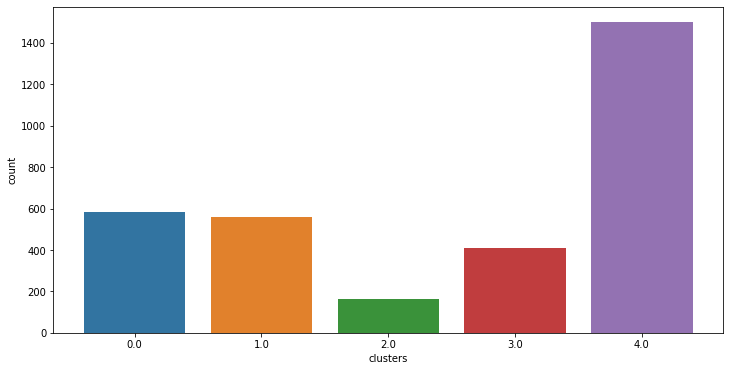

In [62]:
import seaborn as sns

#Visualize the amount of datapoints per cluster
ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(data=counties_kmeans, x="clusters")
plt.plot()

#Count the clusters
count_clusters_df = counties_kmeans["clusters"].value_counts()
count_clusters_df.columns = ["count of clusters"]
count_clusters_df


From the figure above we can see that the data is not evenly clustered. This means that we probably chose a low value for the hyperparameter k. We will perform a hyperparameter tuning job and use both the elbow and silhouette method to find the optimal value for k. 

#### 4.2.2 Hyperparameter tuning K

The first idea was to use the low level API (boto3) to create a hyperparameter tuning job. But from the SageMaker documentation, K is not a tunable parameter. Therefore, I will write a for loop to train different K-means models. 

In [63]:
#First we need to store the data that we will use for training in S3. 
#The data we used for training was counties_transformed. 

#counties_transformed was already saved in this working directory as "train_data_for_kmeans.csv"
train_location = session.upload_data("train_data_for_kmeans.csv", bucket=bucket_name, key_prefix="kmeans_train_data")


In [ ]:
#The hyperparameter K is not tunable with A Hyperparamer Tuning Job. We will tune this model by training a 
#few models with a for loop. Using the help of the blogpost below.
#https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/
#Import the required libraries
from time import strftime
from datetime import datetime
from sagemaker.amazon.amazon_estimator import get_image_uri

#Range of hyperparameter K
K = range(2,11)

#Define the time to set a unique name for our training job
now = datetime.now()
output_time = now.strftime("%Y-%m-%d-%H-%M-%S")

#Set some training job parameters
INSTANCE_COUNT = 1
run_parallel_jobs = False
output_folder = "kmeans-lowlevel" + output_time

#Make a list to store the job names
job_names = []

#Start the for loop 
for k in K:
    
    print("Starting training job with k=" + str(k))
    
    #Place to store the model artifacts in S3
    output_location = "s3://{}/kmeans_tuning_job/output/{}".format(bucket_name, output_folder)
    
    print("Training artifacts will be uploaded to: {}".format(output_location))
    
    #The name of the job. This is unique for all training jobs
    job_name = output_folder + "k" + str(k)
    
    #Set all training job parameters
    training_parameters = {}

    training_parameters["TrainingJobName"] = job_name

    training_parameters["HyperParameters"] = {"k": str(k), "feature_dim": "7"}
    
    training_parameters["RoleArn"] = role

    training_parameters["AlgorithmSpecification"] = {"TrainingImage": get_image_uri(session.boto_region_name, "kmeans"),
                                                     "TrainingInputMode": "File"}
    training_parameters["ResourceConfig"] = {
                "InstanceType": "ml.c4.xlarge",
                "InstanceCount": 1,
                "VolumeSizeInGB": 50
                }

    training_parameters["InputDataConfig"] = [{

                "ChannelName": "train",

                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": train_location,
                        "S3DataDistributionType": "FullyReplicated"
                    }
                },

                "ContentType": "text/csv;label_size=0",
                "CompressionType": "None"
            }]

    training_parameters["OutputDataConfig"] = {

                "S3OutputPath": output_location
            }

    training_parameters["StoppingCondition"] = {

                "MaxRuntimeInSeconds": 60 * 60 
            }
    
    #Start the training job
    session.sagemaker_client.create_training_job(**training_parameters)
    
    #Check the status of the training job
    status = session.sagemaker_client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
    print(status)
    
    #Add a waiter, to wait for the training jobs to complete before proceeding with the code
    if not run_parallel_jobs:
        try:
            session.sagemaker_client.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=job_name)
        finally: #The finally block, if specified, will be executed regardless if the try block raises an error or not.
            status = session.sagemaker_client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
            print("Training job ended with status {}".format(status))
            
            #If the training job fails, get the error message and stop the program with an exception
            if status == "Failed":
                message = session.sagemaker_client.describe_training_job(TrainingJobName=job_name)["FailureReason"]
                print("Training job failed with the following error: \n{}".format(message))
                raise Exception("Training job failed")
    
    #Append the job name to a list
    job_names.append(job_name)
                                                                                  

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Starting training job with k=2
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=3
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=4
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=5
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=6
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=7
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=8
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=9
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Training job ended with status Completed
Starting training job with k=10
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-513808683464/kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23
InProgress
Training job ended with status Completed


##### Note on Waiters:

A number of requests in AWS using boto3 are not instant. Common examples of boto3 requests are deploying a new server or RDS instance. For some long running requests, we are ok to initiate the request and then check for completion at some later time. But in many cases, we want to wait for the request to complete before we move on to the subsequent parts of the script that may rely on a long running process to have been completed. 

(https://www.2ndwatch.com/blog/use-waiters-boto3-write/)

Lets see some of the model attributes for k=10. Again, a model.tar.gz file is created for every training job in which the model artifacts are stored. 

In [70]:
#Continue from here with job names extracted from S3, so that we don't have to run the training jobs again
job_names = session.list_s3_files(bucket=bucket_name, key_prefix="kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23") #If ran again, this name changes because of the timestamp used. 
print(job_names[0])


#Extract model attributes for k=10 which is at job_names[0] by first downloading the model artifacts
session.download_data(path=os.getcwd(), bucket=bucket_name, key_prefix=job_names[0]) #The model is saved in the working directory as model.tar.gz

#Unzip the model files
os.system("tar -zxvf model.tar.gz") #Return a file called model_algo-1 in the working directory
os.system("unzip model_algo-1") #unzip the model_algo-1 file, which is a serialized Apache MXNet object

kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23/kmeans-lowlevel2020-08-21-15-34-23k10/output/model.tar.gz


2304

In [71]:
#Extract the information from the model_algo-1 file
import mxnet as mx

#Load the data
kmeans_model_params = mx.ndarray.load("model_algo-1")
#print(kmeans_model_params)

#Put the data in a DataFrame
kmeans_model_params_df = pd.DataFrame(kmeans_model_params[0].asnumpy())

kmeans_model_params_df

#The rows of kmeans_model_params_df correspond to the cluster centroids and the features are the component space created with PCA earlier. 


,0,1,2,3,4,5,6
0,0.445345,0.264957,0.090921,0.314283,0.098158,-0.081464,0.043802
1,-0.222936,0.011169,-0.010715,-0.050437,-0.033151,-0.026727,-0.005344
2,1.235274,-0.238009,-0.198334,-0.406169,-0.088117,0.094525,0.128143
3,-0.262765,-0.446216,0.098176,0.120398,0.058127,-0.006205,0.107199
4,0.412507,-0.473528,0.123244,0.276057,-0.237998,0.032375,-0.219940
5,0.131584,0.058238,0.088543,0.070982,0.033205,0.035305,-0.012479
6,0.300139,-0.226364,-0.089888,-0.203609,0.177989,-0.139562,-0.062443
7,-0.216059,-0.008706,-0.488760,0.123918,-0.013529,0.106144,-0.022106
8,-0.073651,0.145301,0.170523,-0.103118,-0.028352,0.055767,-0.015613
9,0.058493,0.105750,-0.257428,0.080292,-0.022160,0.021542,0.000688


Above we can see the location of the resulting 10 cluster centroids (because k=10). These cluster centroids are in the PCA transformed component space which has 7 dimensions as we saw before. 

Now we need to find the best value for K, using the elbow and silhouette method. We could use a Batch Transform job for each trained model and obtain to which cluster each datapoint belongs and the distance to that cluster. With this information we could plot the elbow and silhouette graph. But that is a very heavy job considering we have 9 models trained. That is why we will use Sklearn and some basic distance operations using cdist of the scipy.spatial.distance library to determine to which cluster each datapoint belongs and what the distance is. 

In the current working directory there is a file called utils. We will use the function plot_elbow_silhouette(). 

We will use a for loop to import the model artifacts files for each K and store the inertias and silhouette scores. 

In [72]:
from utils import inertia_silhouette_score

#print(job_names) #job_names corresponding K values: [10, 2, 3, 4, 5, 6, 7, 8, 9]

#Set the values of K
K = [10, 2, 3, 4, 5, 6, 7, 8, 9]

#Initialize list
inertias = []
silhouette_scores = []

for i in range(9):
    
    #Get the job name
    job_name = job_names[i]
    print("Jobname = \n{}".format(job_name))
    
    #Extract model attributes for the specific job by first downloading the model artifacts
    session.download_data(path=".", bucket=bucket_name, key_prefix=job_name) #The model is saved in the working directory as model.tar.gz

    #Unzip the model files
    os.system("tar -zxvf model.tar.gz") #Return a file called model_algo-1 in the working directory
    os.system("unzip model_algo-1") #unzip the model_algo-1 file, which is a serialized Apache MXNet object
    
    #Load the data
    cluster_centers = mx.ndarray.load("model_algo-1")
    
    #Convert the data to a numpy array
    cluster_centers = np.array(cluster_centers[0].asnumpy())
    
    #Check the shapes of the data
    print("\nInput data shape: {}".format(counties_transformed.shape))
    print("\nCluster centers data shape: {}".format(cluster_centers.shape))

    #Calculate the inertia and silhouette scores
    inertia, silhouette = inertia_silhouette_score(X=counties_transformed_arr, K=K[i], cluster_centers=cluster_centers)
    
    #Append the score to lists
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    

Jobname = 
kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23/kmeans-lowlevel2020-08-21-15-34-23k10/output/model.tar.gz

Input data shape: (3218, 7)

Cluster centers data shape: (10, 7)

K = 10

distance = 
[[0.60275806 0.29999133 1.46495157 ... 0.46890422 0.34596167 0.22006348]
 [0.75873727 0.25525354 1.50200012 ... 0.4387825  0.34579014 0.27973497]
 [0.11143143 0.88841978 1.22088584 ... 1.05166894 0.75172941 0.69242519]
 ...
 [1.40855183 1.76189812 0.32673134 ... 1.86606767 1.6391196  1.57841288]
 [1.37982321 1.73066861 0.2601483  ... 1.81084998 1.6094468  1.52636218]
 [1.36202247 1.69674913 0.19895276 ... 1.76311115 1.5894019  1.48341739]]

min_distance = 
[0.22006348 0.25525354 0.11143143 ... 0.32673134 0.2601483  0.19895276]

Inertia = 314.41769888455497

Clusters = 
[9 1 0 ... 2 2 2]

For k = 10 , The average silhouette_score is : 0.18907399475574493

----------------------------------------------------------------------------------------------

Jobname = 
kmeans_tuning_

Lets plot the elbow and silhouette graph now that we got the list of inertias and silhouette scores for different K's. 

[(2, 3, 4, 5, 6, 7, 8, 9, 10), (0.34929487, 0.23927638, 0.23228729, 0.24967222, 0.2230288, 0.27506462, 0.19670631, 0.19868703, 0.189074), (717.0964499464866, 647.8807059335684, 577.1922713573499, 464.88559681378325, 404.98567374810125, 371.8111006649859, 346.304459348991, 325.4387906195981, 314.41769888455497)]


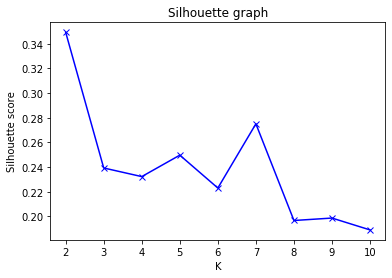

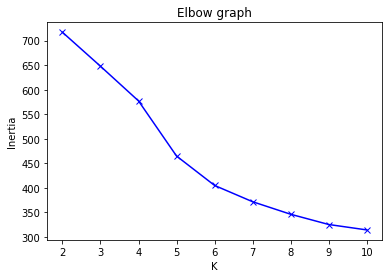

In [73]:
#Lets first order our K values. 
data = list(zip(K, silhouette_scores, inertias))
data = sorted(data)
data = list(zip(*data))
print(data)

#Extract the different lists for K, inertias and silhouette scores
K = list(data[0])
silhouette_scores=list(data[1])
inertias = list(data[2])

#Plot the silhouette graph
plt.plot(K, silhouette_scores, "bx-")
plt.title("Silhouette graph")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()

plt.plot(K, inertias, "bx-")
plt.title("Elbow graph")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()



The results are a bit weird. The elbow graph doesn't really have an elbow and the silhouette graph goes up and down. This maybe means that k-means isn't the best algorithm to use for this data. The underlying assumptions of K-means probably don't held up in this case. K-means works best with isotropic gaussian data. Let see how the 7 dimensional input data looks like. The input data was counties_transformed.  

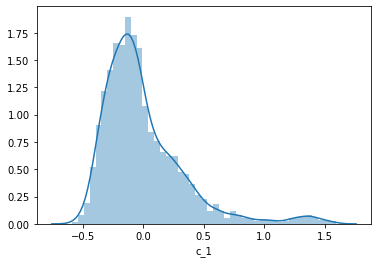

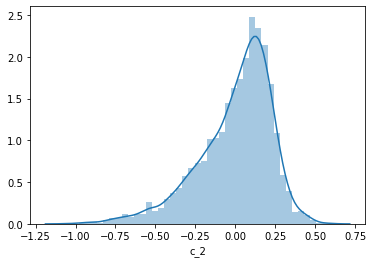

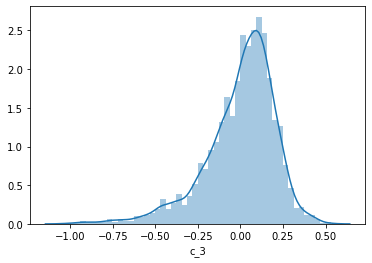

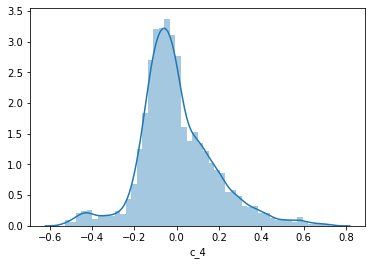

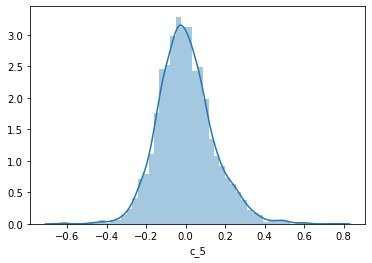

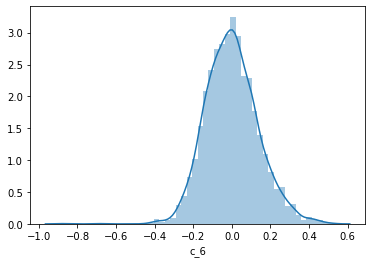

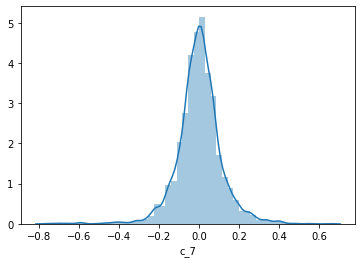

In [80]:
import seaborn as sns
for i in list(counties_transformed.columns): 
    sns.distplot(counties_transformed[i])
    plt.show()

We can see that the data has a Gaussian distribution. Some assumptions of K-means are:
- The data should have a Gaussian Distribution
- The data should be isotropic (circular, spherical or hyperspherical)
- The clusters should all have even sizes

For now, I will stick with k=7, as this has a low inertia and high silhouette score. Lets create a model with the k=7 model attributes so that we can make inference on the dataset, this will gives us the cluster assignments for each datapoint. 

In [85]:
#Name of the job with k=7
job_name = job_names[6]
print(job_name)

#Create the model
from sagemaker import KMeansModel
kmeans_7 = KMeansModel(model_data="s3://{}/{}".format(bucket_name, job_name),
                       role=role,
                       sagemaker_session=session)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


kmeans_tuning_job/output/kmeans-lowlevel2020-08-21-15-34-23/kmeans-lowlevel2020-08-21-15-34-23k7/output/model.tar.gz


Deploy the k-means model to make predictions.

In [86]:
%%time

#Deploy the model
kmeans_7_predictor = kmeans_7.deploy(initial_instance_count=1,
                                     instance_type="ml.t2.medium")

-----------------!CPU times: user 286 ms, sys: 20.2 ms, total: 306 ms
Wall time: 8min 32s


Now we can make predictions on our counties_transformed data.

In [90]:
pred = kmeans_7_predictor.predict(counties_transformed_arr)

As before we need to parse the information from the result of the predict function. We did this earlier with the create_cluster_df function. Lets do it again. 

In [95]:
counties_kmeans = create_cluster_df(pred, counties_transformed)
counties_kmeans.head()

,clusters,distance_to_clusters
Alabama-Autauga,4.0,0.276028
Alabama-Baldwin,4.0,0.260946
Alabama-Barbour,1.0,0.220634
Alabama-Bibb,4.0,0.436597
Alabama-Blount,4.0,0.330038


Plot the cluster data: 

4.0    1536
0.0     457
3.0     434
1.0     432
2.0     208
5.0      91
6.0      60
Name: clusters, dtype: int64

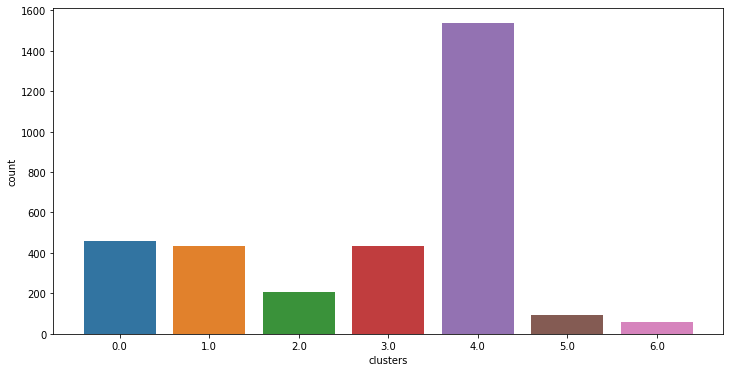

In [96]:
#Visualize the amount of datapoints per cluster
ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(data=counties_kmeans, x="clusters")
plt.plot()

#Count the clusters
count_clusters_df = counties_kmeans["clusters"].value_counts()
count_clusters_df.columns = ["count of clusters"]
count_clusters_df

Again, we see that a lot of datapoints belong to the same cluster, which could be because of the K-means algorithm and its assumptions. 

Now we know which counties belong to the same cluster. These counties have some similarities. Lets see which counties are in the same cluster.

In [98]:
#Cluster 0
counties_kmeans[counties_kmeans["clusters"] == 0]

,clusters,distance_to_clusters
Alabama-Elmore,0.0,0.301107
Alabama-Lee,0.0,0.350816
Alabama-Madison,0.0,0.255404
Alabama-Shelby,0.0,0.253417
Alaska-Anchorage Municipality,0.0,0.298365
...,...,...
Wisconsin-St. Croix,0.0,0.379673
Wisconsin-Washington,0.0,0.445425
Wisconsin-Waukesha,0.0,0.448990
Wyoming-Laramie,0.0,0.324123


In [99]:
#Cluster 1
counties_kmeans[counties_kmeans["clusters"] == 1]

,clusters,distance_to_clusters
Alabama-Barbour,1.0,0.220634
Alabama-Bullock,1.0,0.625193
Alabama-Butler,1.0,0.163451
Alabama-Calhoun,1.0,0.315917
Alabama-Chambers,1.0,0.305626
...,...,...
Virginia-Portsmouth city,1.0,0.298388
Virginia-Richmond city,1.0,0.404026
Virginia-Roanoke city,1.0,0.354695
West Virginia-McDowell,1.0,0.610363


This is the end of the notebook. In short we did the following:
1. Import the data
2. Clean and prepare the data
3. Perform PCA to reduce the dimensionality
4. Train a K-means model (k=5) to see how everything works
5. Perform hyperparameter optimization to find the best value for k
6. Create a model with best k
7. Look at natural groupings: which counties belong to the same cluster

## END Notes
Other good clustering algorithms that could be used are **Gaussian Mixture Models** and **DBSCAN**. I give a brief overview of these algorithms: 
- **Gaussian Mixture Models (GMM)**: GMM's assume that there are a certain number of Gaussian distributions, and each of these distributions represent a cluster. Hence, a GMM tends to group the data points belonging to a single distribution together.  GMM's are probabilistic models and use the soft clustering approach for distributing the points in different clusters. 

- **DBSCAN**: DBSCAN stand for **D**ensity **B**ased **S**patial **C**lustering of **A**pplications with **N**oise. It is able to find arbitrary shaped clusters and clusters with noise (e.i. outliers). The main idea behind DBSCAN is that a datapoint belongs to a cluster if it is close to many points from that cluster.

## Helper functions

In [ ]:
#Use to get the methods and attributes of a class
#dir(session)

In [ ]:
#Get information about an object
#help(session)